<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Заключение" data-toc-modified-id="Заключение-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Заключение</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-DecisionTreeRegressor" data-toc-modified-id="Модель-DecisionTreeRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель DecisionTreeRegressor</a></span></li><li><span><a href="#Модель-RandomForestRegressor" data-toc-modified-id="Модель-RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Модель-LightGBM" data-toc-modified-id="Модель-LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель LightGBM</a></span></li><li><span><a href="#Модель-DummyRegressor" data-toc-modified-id="Модель-DummyRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Модель DummyRegressor</a></span></li><li><span><a href="#Заключение" data-toc-modified-id="Заключение-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Заключение</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Заключение" data-toc-modified-id="Заключение-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Заключение</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

**Подгрузим библиотеки.**

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import Pool, CatBoostRegressor
import lightgbm as lgb
from numpy.random import RandomState
from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyRegressor

**Загрузим датасет и сделаем индексами колонку с датами.**

In [48]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

**Посмотрим общую информацию о наборе данных.**

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Посмотрим, если пропуски.**

In [50]:
print('Количество пропусков в наборе данных -', data.isna().sum())

Количество пропусков в наборе данных - num_orders    0
dtype: int64


**Предварительно посмотрим на содержание датасета.**

In [51]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


**Обратим внимание, данные о заказах получали с переодичностью в 10 минут.**

**Посмотрим на наличие дубликатов**

In [52]:
print('\nКоличество явных дубликатов -', data.duplicated().sum())


Количество явных дубликатов - 26415


**Наличие явных дубликатов может означать, что для определлных временных периодов присутствует цикличность. Считаю их удаление не целесообразным.**

**Проверим, расположены ли даты в наборе по порядку.**

In [53]:
if (data.index.is_monotonic) is True:
    print('\nДаты в наборе данных расположены по порядку')
elif (data.index.is_monotonic) is not True:
    print('\nДаты в наборе данных расположены не по порядку')


Даты в наборе данных расположены по порядку


**Посмотрим на распределение значений в колонке "Заказы".**

No handles with labels found to put in legend.


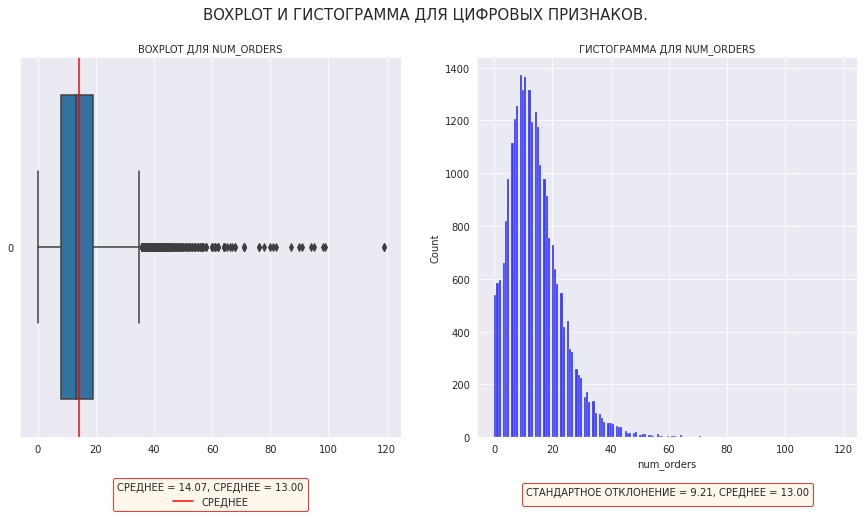

In [54]:
plt.figure(figsize=[15, 7])
plt.suptitle('BOXPLOT И ГИСТОГРАММА ДЛЯ ЦИФРОВЫХ ПРИЗНАКОВ.', fontsize=15)
plt.subplot(1, 2, 1)
plt.title(f'BOXPLOT ДЛЯ NUM_ORDERS', fontsize=10)
sns.set_style('darkgrid')
sns.boxplot(data=data['num_orders'], orient='h')
plt.axvline(np.mean(data['num_orders']), 
            color='r', 
            linestyle='-',
            label='СРЕДНЕЕ')
median = np.mean(data['num_orders'])
mean = np.median(data['num_orders'])
plt.legend(title=f'СРЕДНЕЕ = {median:.2f}, СРЕДНЕЕ = {mean:.2f}', 
           loc='center', 
           edgecolor = 'r',
           facecolor = 'oldlace',
           bbox_to_anchor=(0.5, -0.15))
plt.subplot(1, 2, 2)
sns.set_style('darkgrid')
plt.title(f'ГИСТОГРАММА ДЛЯ NUM_ORDERS', fontsize=10)
sns.histplot(data=data['num_orders'], color='b', kde=False)
std = data['num_orders'].std()
plt.legend(title=f'СТАНДАРТНОЕ ОТКЛОНЕНИЕ = {std:.2f}, СРЕДНЕЕ = {mean:.2f}', 
           loc='center', 
           edgecolor = 'r',
           facecolor = 'oldlace',
           bbox_to_anchor=(0.5, -0.15))
plt.show();

 1. **Медианна больше среднего, а значит датасет имеет положительный скос в сторону дополнительных значений.**
 
 
 2. **Разброс данных не большой.**
 
 
 3. **Гистограмма приближена к графику нормального распределения.**
 
 
 4. **Присутствуют дополнительные значения/выбросы.**

**Посмотрим на значения в колоке "Количество заказов".**

In [55]:
np.sort(data['num_orders'].unique())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  60,  61,  62,  64,  65,  66,
        67,  68,  71,  76,  78,  80,  81,  82,  87,  90,  91,  94,  95,
        98,  99, 119])

**Аномальные значения в содержании колонки отсутствуют.**

**Изменим интревал со значениями ряда (выполним рассемплирование). В качестве агрегирующей функции используем суммирование по количеству заказов.**

In [56]:
data = data.resample('1H').sum()

### Заключение

 - **Пропуски в данных отсутствуют.**
 
 
 - **В данных есть дубликаты. Их наличие может означать присутствие цикличности для определенных временных периодов в заказах.**
 
 
 - **Даты расположены по порядку.**
 
 
 - **Распределение данных близко к нормальному, стандартное отклонение имеет не большие значения.**
 
 
 - **В данных присутствуют дополнительные значения ( выбросы). Считаю, что их удаление не нужным, так как можно потерять важную информацию.**
 
 
 - **Начальный интервал получения данных был 10 минут, выполнено рассемплирование данных ( получение нового интервала) с интервалом в 1 час.**

## Анализ

**Построим график, и оценим тип временного ряда.**

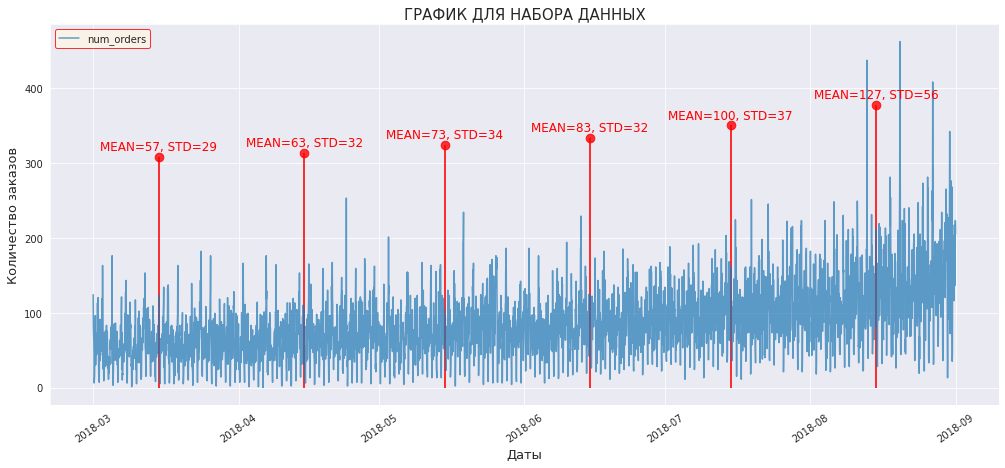

In [57]:
plt.figure(figsize=[17, 7])
plt.title(f'ГРАФИК ДЛЯ НАБОРА ДАННЫХ', fontsize=15)
sns.set_style('darkgrid')
plt.plot(data, label='num_orders', alpha=0.7)
plt.xticks(fontsize=10, rotation=35)
for month in data.index.month.unique():
    mean_for_month = np.mean(data[f"2018-{month}":f"2018-{month}"])
    std_for_month = np.std(data[f"2018-{month}":f"2018-{month}"])
    plt.vlines(pd.to_datetime(f'2018-{month}-15'),
                ymin=0,
                ymax=(mean_for_month)+250,
                color='r',
                alpha=0.8,
                linewidth=2)
    plt.scatter(x=pd.to_datetime(f'2018-{month}-15'),
                y=(mean_for_month)+250,
                s=75,
                color='r',
                alpha=0.8)
    plt.text(x=pd.to_datetime(f'2018-{month}-15'),
             y=(mean_for_month)+255,
             s=f'MEAN={int(mean_for_month)}, STD={int(std_for_month)}',
             horizontalalignment= 'center',
             verticalalignment='bottom',
             fontsize=12,
             color='r')
plt.ylabel('Количество заказов', fontsize=13)
plt.xlabel('Даты', fontsize=13)
plt.grid(True)
plt.legend(edgecolor = 'r', facecolor = 'oldlace');

**График описывает не стационарный ряд, так как его среднее и стандартное отклонение меняются. Нестационарные ряды  трудно прогнозировать, их свойства быстро меняются.**

**Необходимо сделать ряд стационарным. Для этого добавим новые признаки для горизонта прогнозирования:**

 1. **<u>Календарные признаки:</u>**
  - **Год**
  - **Месяц**
  - **День(число)**
  - **День недели**
 
 
 2. **<u>Отстающие значения.</u>**
  - **Предыдущие значения временного ряда покажут, будет ли функция $x(t)$ расти или уменьшатся.**
  
  
 3. **<u>Скользящее среднее.</u>**
  - **Его суть заключается в поиске значений, которые меньше всего подвержены колебаниям, то есть средних арифметических.**

In [58]:
def make_features(data, max_lag, rolling_mean_size):
#     data['year'] = data.index.year
#     data['month'] = data.index.month
#     data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
 #Вычисление скол-го среднего не должно включать в себя текущее значение ряда.
 #Иначе будет утечка целевого признака. Поэтому, добавил метод shift()    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [59]:
make_features(data, 2, 24)

**Посмотрим на данные.**

In [60]:
data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,NaN


**Для первых дат есть не все отстающие значения, поэтому в этих строках стоят NaN. Удалим такие строки.**

In [62]:
str_with_nan = data.shape[0] - data.dropna().shape[0]
print(f'\nКоличество строк с пропусками - {str_with_nan}')


Количество строк с пропусками - 24


In [63]:
data = data.dropna()

**Разобъем датасет на тренды и сезонность. Построим их графики и проанализируем результаты.**

In [64]:
decomposed = seasonal_decompose(data['num_orders'])

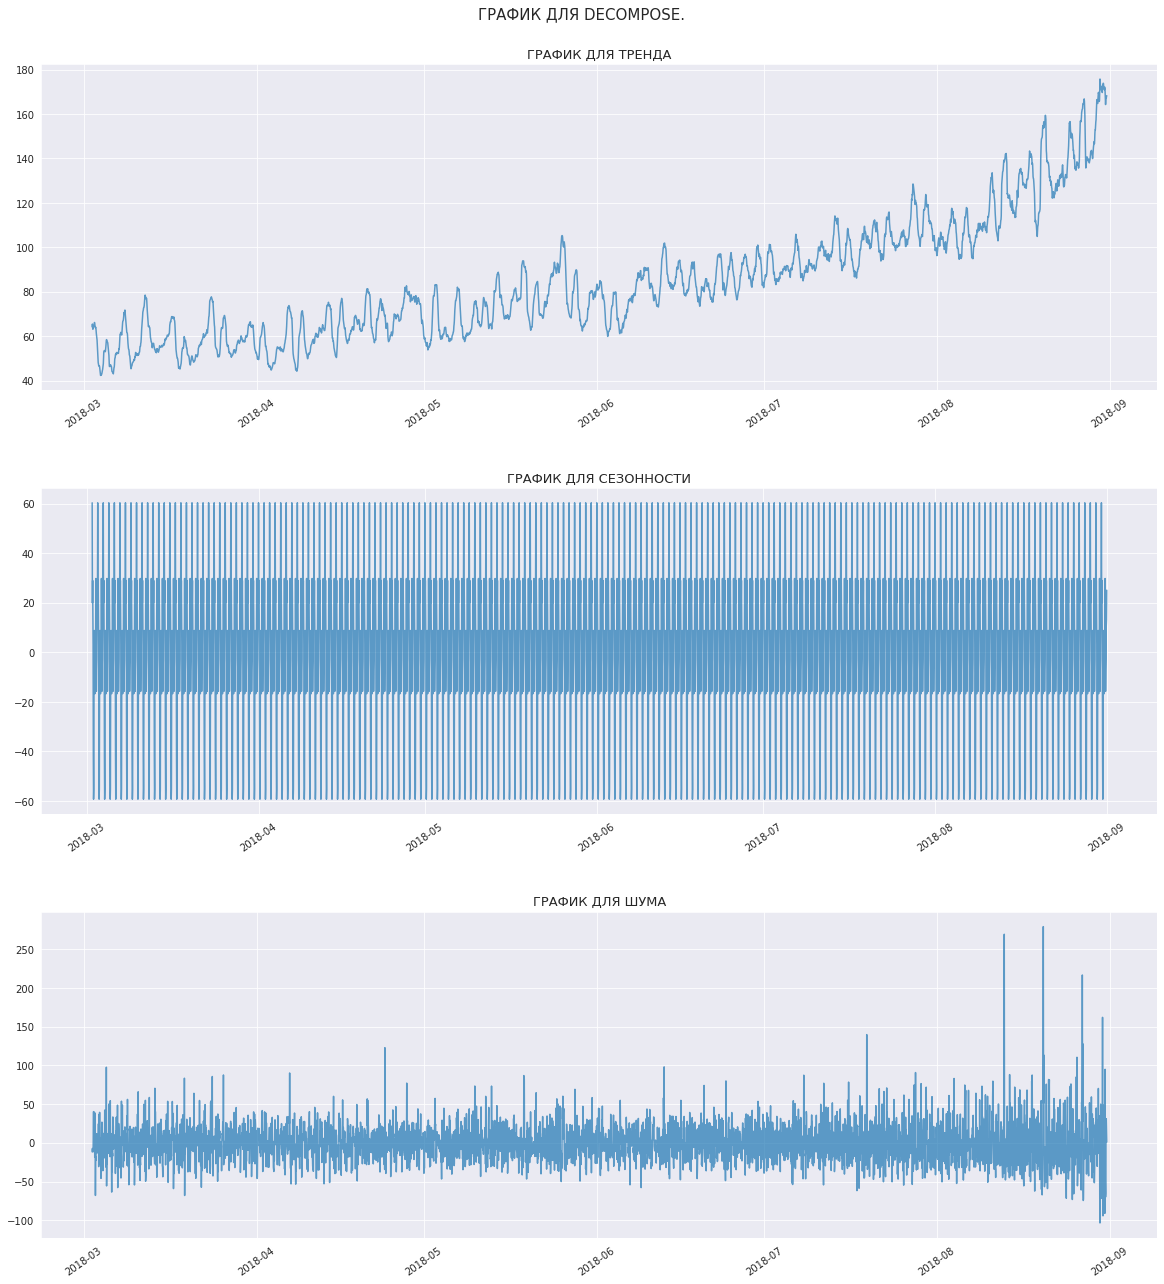

In [36]:
plt.figure(figsize=[20, 20])
plt.subplots_adjust(top=0.94, wspace=0.3, hspace=0.30)
plt.suptitle('ГРАФИК ДЛЯ DECOMPOSE.', fontsize=15)
sns.set_style('darkgrid')
plt.subplot(3, 1, 1)
plt.title(f'ГРАФИК ДЛЯ ТРЕНДА', fontsize=13)
plt.plot(decomposed.trend, alpha=0.7)
plt.xticks(fontsize=10, rotation=35)
plt.subplot(3, 1, 2)
plt.title(f'ГРАФИК ДЛЯ СЕЗОННОСТИ', fontsize=13)
plt.plot(decomposed.seasonal, alpha=0.7)
plt.xticks(fontsize=10, rotation=35)
plt.subplot(3, 1, 3)
plt.title(f'ГРАФИК ДЛЯ ШУМА', fontsize=13)
plt.plot(decomposed.resid, alpha=0.7)
plt.xticks(fontsize=10, rotation=35);

 - **График RESID (компонента, которая не обьясняется сезонностью и трендом) анализировать не будем, это шум.**


- **График сезонности похож на станционарный стохастический процесс (колебания переодичны), его распределение со временем не меняется, есть повторяющиеся закономерности.**
 
 
 - **График тренда заметно увеличение количества заказов в период с мая к концу августа.**


**Попробуем проанализировать данные по дням недели.**

In [65]:
decompose_second = seasonal_decompose(data["2018":"2018"]['num_orders'])

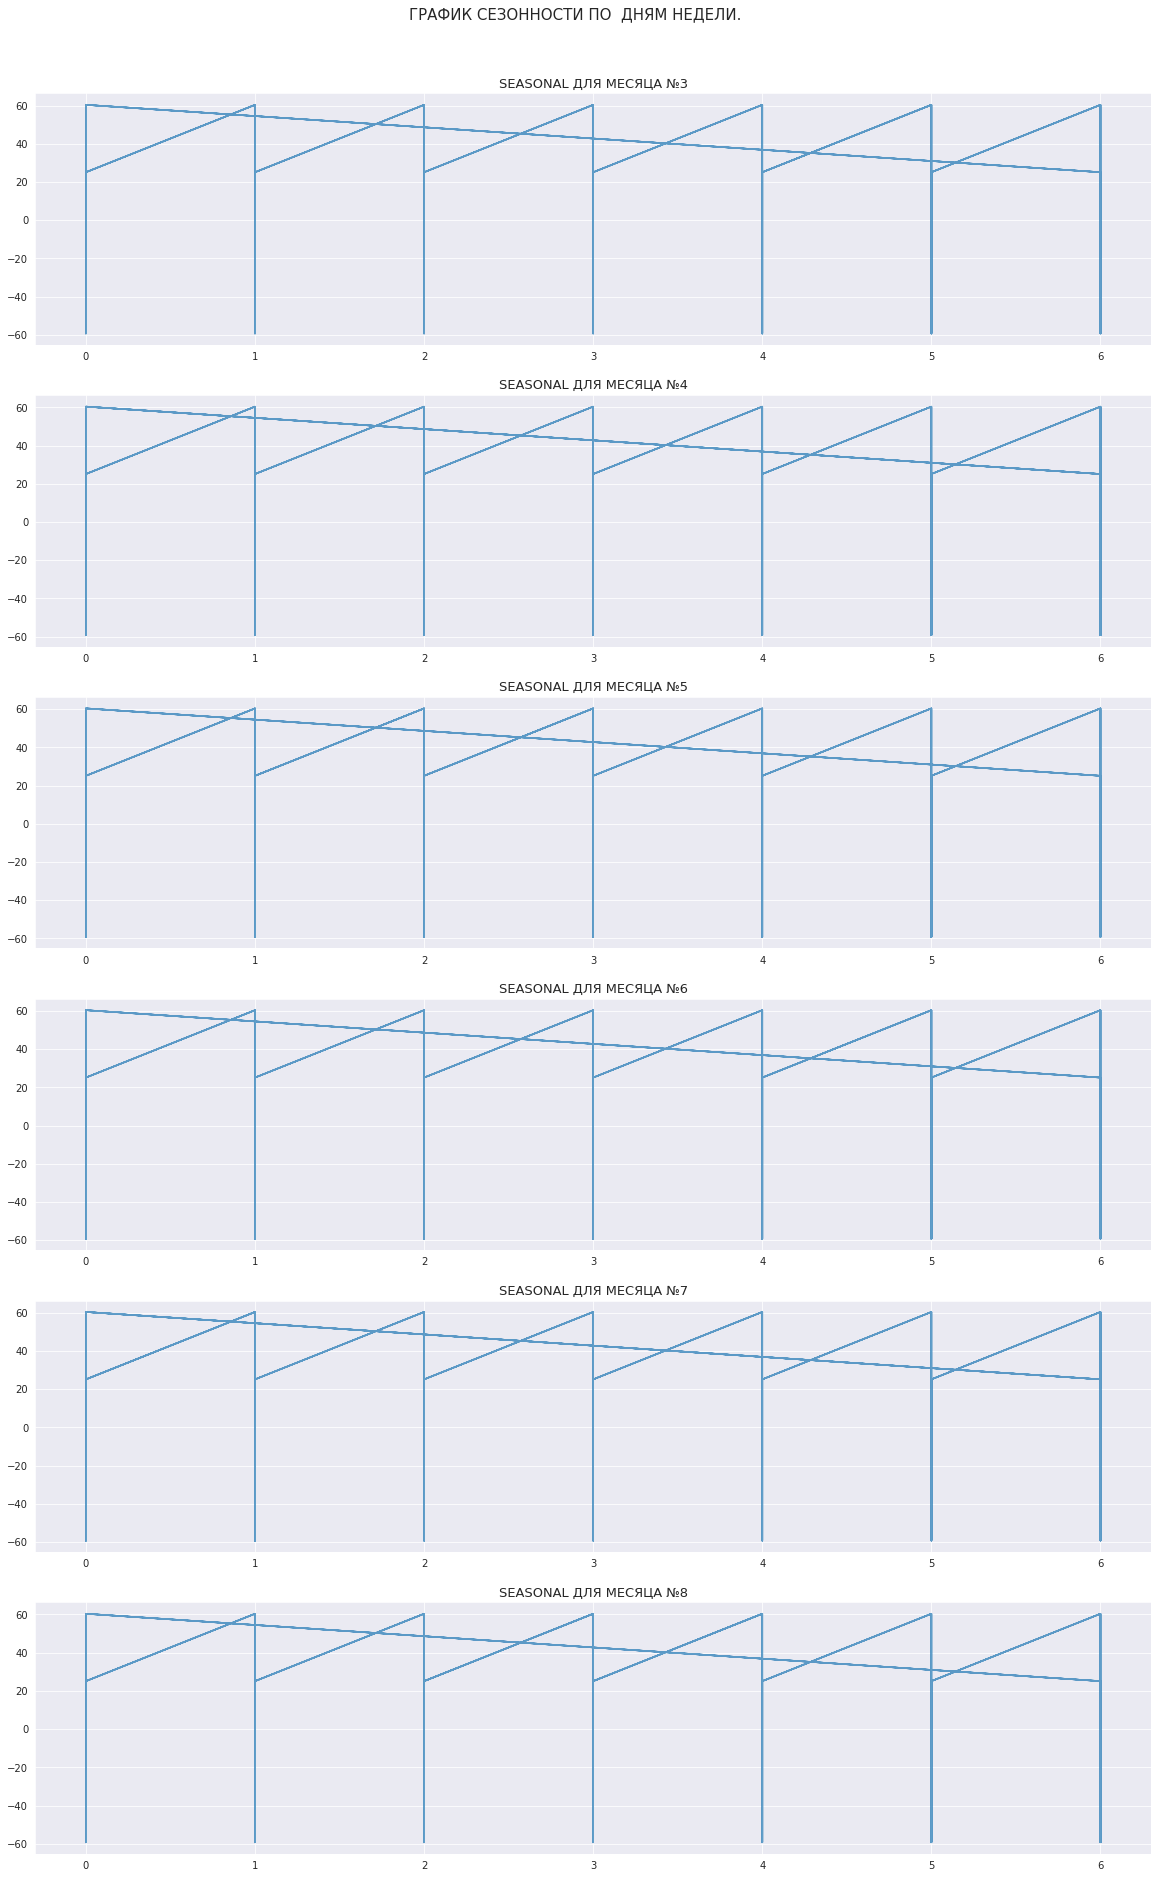

In [66]:
position = 0
plt.figure(figsize=[20, 30])
plt.subplots_adjust(top=0.94)
plt.suptitle('ГРАФИК СЕЗОННОСТИ ПО  ДНЯМ НЕДЕЛИ.', fontsize=15)
sns.set_style('darkgrid')
for month in data.index.month.unique(): 
    position += 1
    plt.subplot(6, 1, position)
    plt.title(f"SEASONAL ДЛЯ МЕСЯЦА №{month}", fontsize=13)
    plt.plot(decompose_second.seasonal[f'2018-{month}':f'2018-{month}'].index.dayofweek,
             decompose_second.seasonal[f'2018-{month}':f'2018-{month}'].values,
             alpha=0.7)
plt.show();

**На графике сезонности наблюдаетя цикличность: в начале дня количетсво заказов растет, потом снижается, а к концу дня снова растет.**

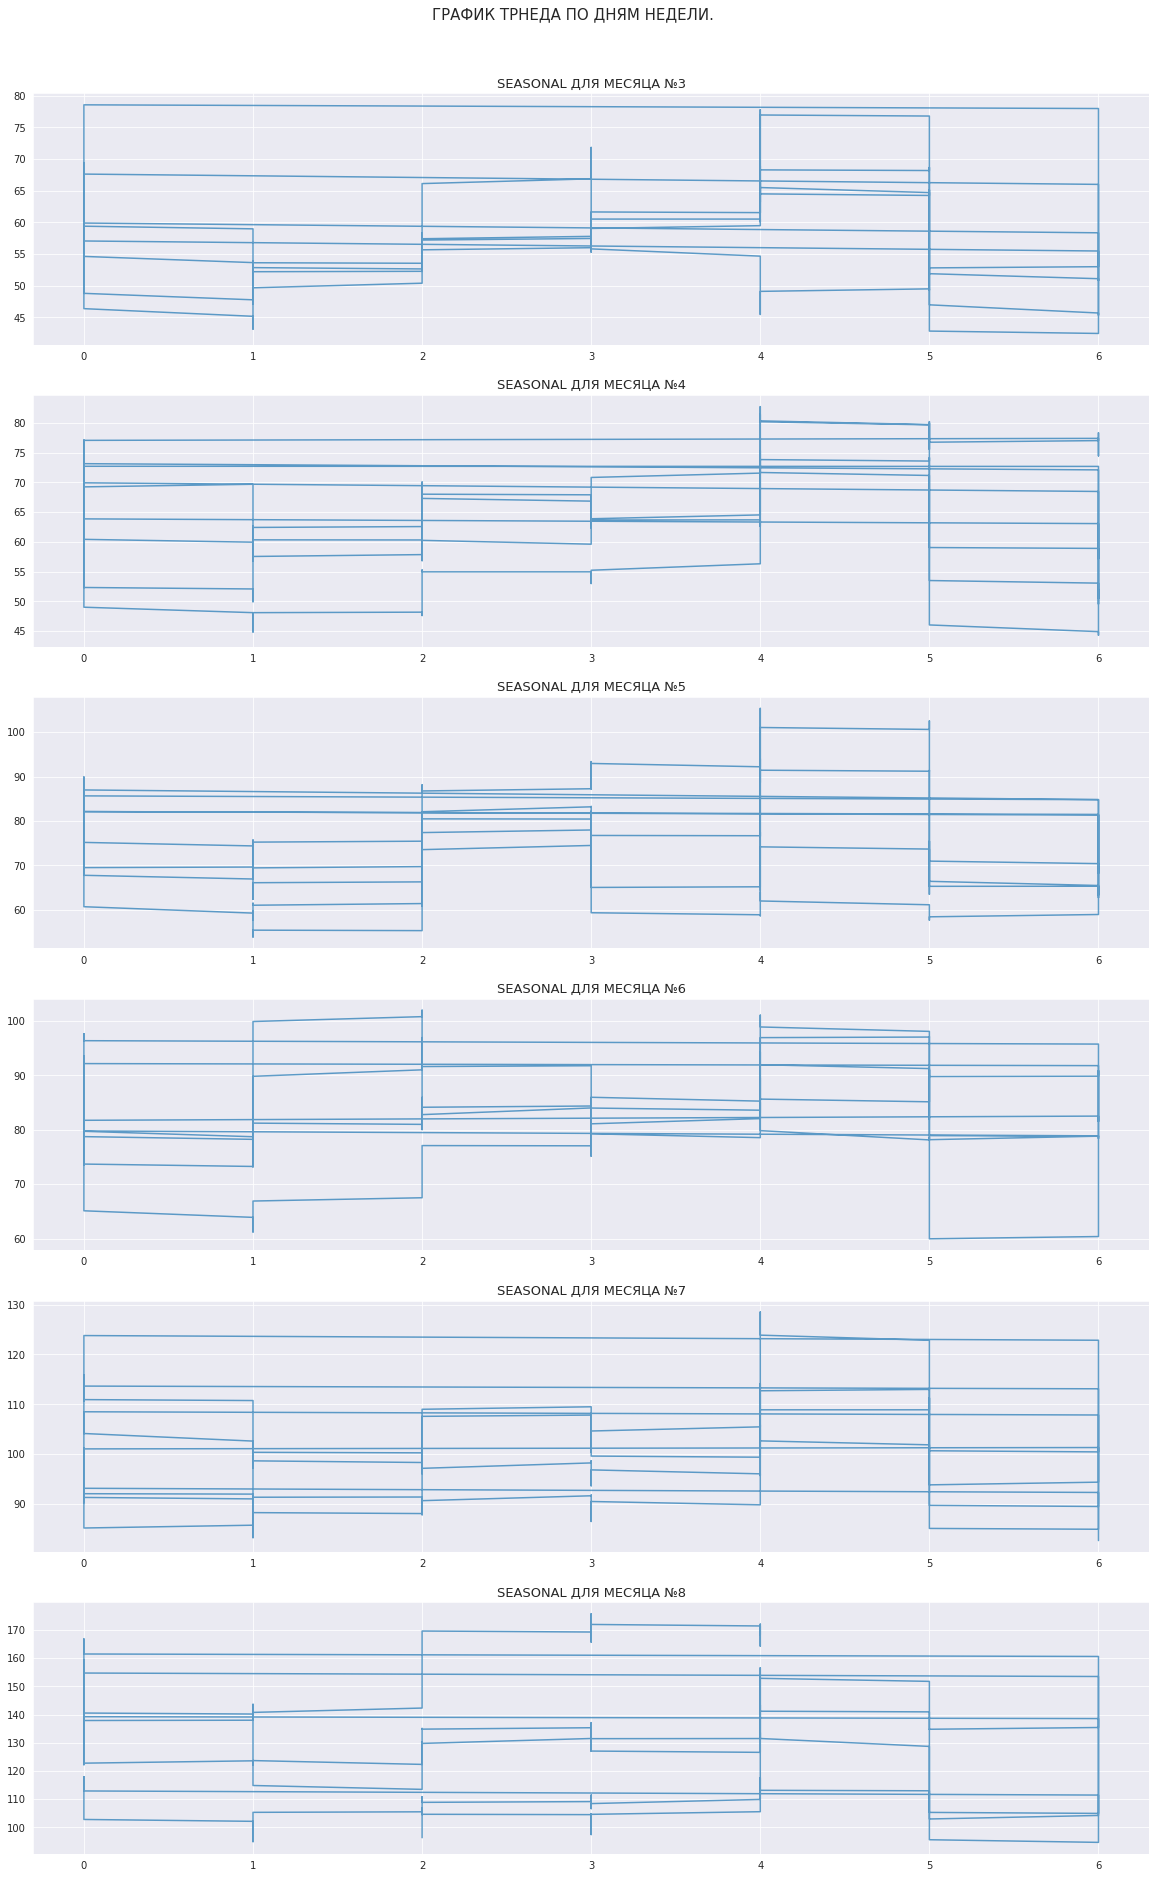

In [67]:
position = 0
plt.figure(figsize=[20, 30])
plt.subplots_adjust(top=0.94)
plt.suptitle('ГРАФИК ТРНЕДА ПО ДНЯМ НЕДЕЛИ.', fontsize=15)
sns.set_style('darkgrid')
for month in data.index.month.unique(): 
    position += 1
    plt.subplot(6, 1, position)
    plt.title(f"SEASONAL ДЛЯ МЕСЯЦА №{month}", fontsize=13)
    plt.plot(decompose_second.trend[f'2018-{month}':f'2018-{month}'].index.dayofweek,
             decompose_second.trend[f'2018-{month}':f'2018-{month}'].values,
             alpha=0.7)
plt.show();

**На графиках присутствует ренд роста числа заказов в понедельник и в выходные, снижения во вторник. По мере приближения лета, количество заказов так же увеличивается.**

### Вывод

**В графике сезонности наблюдаеются повторяющиеся закономерности, он стационарен. В графике трендов по дням недели обнаружена закономерность роста числа заказов в начале и конце недели, и снижния числа заказов в середине недели, а так же рост числа заказов в период с мая по август.**

## Обучение

**Разделим датасет на тренировчку и тестовую выборки.**

In [68]:
dct_with_params = {}

In [69]:
state = RandomState(12345)

In [70]:
train,test = train_test_split(data ,shuffle=False, random_state = state, test_size = 0.1)

In [71]:
print('Размер тестовой выборки - %.2f' % (test.shape[0] / train.shape[0]))

Размер тестовой выборки - 0.11


In [72]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [73]:
del data, train, test

In [74]:
splits = TimeSeriesSplit(n_splits=9)

### Модель DecisionTreeRegressor

In [75]:
%%time
model_dt_for_search = DecisionTreeRegressor()
param = dict(max_depth=np.arange(1,10,1), splitter=['best', 'random'])
dtr = RandomizedSearchCV(model_dt_for_search,
                         param,
                         cv=splits,
                         scoring='neg_mean_squared_error',
                         random_state=state)
dtr.fit(features_train, target_train)
score_rmse = (-dtr.best_score_) ** 0.5
dct_with_params['DT'] = dtr.best_params_
dct_with_params['DT'].update(train_rmse=score_rmse)

CPU times: user 546 ms, sys: 0 ns, total: 546 ms
Wall time: 545 ms


In [76]:
del model_dt_for_search, dtr

In [77]:
%%time
test_model_dt = DecisionTreeRegressor(max_depth=dct_with_params['DT']['max_depth'],
                                      splitter=dct_with_params['DT']['splitter'],
                                      random_state=state)
test_model_dt.fit(features_train, target_train)

CPU times: user 10.7 ms, sys: 305 µs, total: 11.1 ms
Wall time: 9.53 ms


DecisionTreeRegressor(max_depth=6,
                      random_state=RandomState(MT19937) at 0x7F0470952B40)

### Модель RandomForestRegressor

In [78]:
%%time
model_random_forest_for_search = RandomForestRegressor()
params = dict(max_depth=[10,50], n_estimators=np.arange(10,150,10), n_jobs=[1,-1])
rfr = RandomizedSearchCV(model_random_forest_for_search,
                         params,
                         cv=splits,
                         scoring='neg_mean_squared_error',
                         random_state=state)
rfr.fit(features_train, target_train)
score_rmse = (-rfr.best_score_) ** 0.5
dct_with_params['RF'] = rfr.best_params_
dct_with_params['RF'].update(train_rmse=score_rmse)

CPU times: user 35.6 s, sys: 107 ms, total: 35.8 s
Wall time: 35.8 s


In [79]:
del model_random_forest_for_search, rfr

In [80]:
%%time
test_model_rf = RandomForestRegressor(n_estimators=dct_with_params['RF']['n_estimators'],
                                      max_depth=dct_with_params['RF']['max_depth'],
                                      n_jobs=dct_with_params['RF']['n_jobs'],
                                      random_state=state)
test_model_rf.fit(features_train, target_train)

CPU times: user 1.13 s, sys: 3.83 ms, total: 1.13 s
Wall time: 1.14 s


RandomForestRegressor(max_depth=50, n_estimators=120, n_jobs=1,
                      random_state=RandomState(MT19937) at 0x7F0470952B40)

### CatBoostRegressor 

In [81]:
%%time
train_pool = Pool(features_train, target_train)
cat = CatBoostRegressor(loss_function="RMSE", verbose=False)
params = {"depth": [5,10]}
grid_search_results = cat.grid_search(params,
                                      train_pool,
                                      cv=splits,
                                      verbose=False,
                                      plot=False)


bestTest = 33.32325901
bestIteration = 463


bestTest = 37.41383523
bestIteration = 456

Training on fold [0/9]

bestTest = 20.81255111
bestIteration = 246

Training on fold [1/9]

bestTest = 20.04339227
bestIteration = 898

Training on fold [2/9]

bestTest = 22.97700485
bestIteration = 756

Training on fold [3/9]

bestTest = 24.44310106
bestIteration = 550

Training on fold [4/9]

bestTest = 22.50794932
bestIteration = 941

Training on fold [5/9]

bestTest = 24.87829404
bestIteration = 393

Training on fold [6/9]

bestTest = 22.75204116
bestIteration = 685

Training on fold [7/9]

bestTest = 29.36987425
bestIteration = 412

Training on fold [8/9]

bestTest = 29.73004914
bestIteration = 988

CPU times: user 15.1 s, sys: 395 ms, total: 15.5 s
Wall time: 19.4 s


In [82]:
dct_with_params['CBR'] = grid_search_results['params']

In [83]:
%%time
test_cat = CatBoostRegressor(depth=dct_with_params['CBR']['depth'], 
                              loss_function='RMSE',verbose=False)                            
test_cat.fit(train_pool)

CPU times: user 1.06 s, sys: 98.6 ms, total: 1.15 s
Wall time: 2.08 s


In [84]:
del train_pool, cat

In [85]:
dct_with_params['CBR'].update(train_rmse=test_cat.get_best_score()['learn']['RMSE'])

### Модель LightGBM

In [86]:
lgb_train = lgb.Dataset(features_train,
                        target_train,
                        free_raw_data=False)
lgb_test = lgb.Dataset(features_test,
                       target_test,
                       free_raw_data=False)

In [87]:
%%time
lgb_model_for_search = lgb.LGBMRegressor()
params = {'max_depth': [5,10,15,20], 'learning_rate': [0.1, 0.2], 'n_jobs': [1,-1]}
lgb_search_best_param = RandomizedSearchCV(lgb_model_for_search, 
                                           params,
                                           cv=splits,
                                           scoring='neg_mean_squared_error',
                                           random_state=state)
lgb_search_best_param.fit(features_train, target_train)
score_rmse = (-lgb_search_best_param.best_score_) ** 0.5

CPU times: user 4.92 s, sys: 320 ms, total: 5.24 s
Wall time: 5.39 s


In [88]:
dct_with_params['LGB'] = lgb_search_best_param.best_params_
dct_with_params['LGB'].update(train_rmse=score_rmse)

In [89]:
%%time
params = {'metric': 'rmse',
         'max_depth':dct_with_params['LGB']['max_depth'],
         "random_state": 12345,
         "learning_rate":dct_with_params['LGB']['learning_rate'],
         'n_jobs': dct_with_params['LGB']['n_jobs']}
test_model_lgb = lgb.train(params,  
                           lgb_train,
                           valid_sets=[lgb_test],
                           num_boost_round=1000)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 78.451417
[1]	valid_0's rmse: 80.4422
[2]	valid_0's rmse: 76.5234
[3]	valid_0's rmse: 73.6421
[4]	valid_0's rmse: 70.6749
[5]	valid_0's rmse: 68.311
[6]	valid_0's rmse: 66.4608
[7]	valid_0's rmse: 64.8303
[8]	valid_0's rmse: 63.312
[9]	valid_0's rmse: 61.8318
[10]	valid_0's rm

### Модель DummyRegressor

In [90]:
%%time
dummy_regr_for_search = DummyRegressor()
params = dict(strategy=['median','mean'], quantile=np.arange(0.1,1,0.1))
dmr = RandomizedSearchCV(dummy_regr_for_search,
                         params, 
                         cv=splits,
                         scoring='neg_mean_squared_error',
                         random_state=state)
dmr.fit(features_train, target_train)
score_rmse = (-dmr.best_score_) ** 0.5
dct_with_params['DMR'] = dmr.best_params_
dct_with_params['DMR'].update(train_rmse=score_rmse)

CPU times: user 155 ms, sys: 3.82 ms, total: 159 ms
Wall time: 174 ms


In [92]:
del dummy_regr_for_search, dmr

In [93]:
test_dummy_regressor = DummyRegressor(strategy=dct_with_params['DMR']['strategy'],
                                      quantile=dct_with_params['DMR']['quantile'])
test_dummy_regressor.fit(features_train, target_train)

DummyRegressor(quantile=0.9)

In [94]:
del lgb_model_for_search, lgb_search_best_param, features_train, target_train

### Заключение

 - **Подобраны лучшие параметры**
 
 - **Модели обучены**

## Тестирование

In [95]:
%%time
dt_rmse = mean_squared_error(target_test,test_model_dt.predict(features_test),squared=False)

CPU times: user 3.2 ms, sys: 0 ns, total: 3.2 ms
Wall time: 2.6 ms


In [96]:
dct_with_params['DT'].update(test_rmse=dt_rmse)

In [97]:
%%time
rf_rmse = mean_squared_error(target_test,test_model_rf.predict(features_test),squared=False)

CPU times: user 19.5 ms, sys: 117 µs, total: 19.6 ms
Wall time: 18.2 ms


In [98]:
dct_with_params['RF'].update(test_rmse=rf_rmse)

In [99]:
%%time
cbr_rmse = mean_squared_error(target_test,test_cat.predict(features_test),squared=False)

CPU times: user 3.33 ms, sys: 0 ns, total: 3.33 ms
Wall time: 2.13 ms


In [100]:
dct_with_params['CBR'].update(test_rmse=cbr_rmse)

In [101]:
%%time
lgb_rmse = mean_squared_error(target_test,test_model_lgb.predict(features_test),squared=False)

CPU times: user 46 ms, sys: 0 ns, total: 46 ms
Wall time: 45.4 ms


In [102]:
dct_with_params['LGB'].update(test_rmse=lgb_rmse)

In [103]:
dmr_rmse = mean_squared_error(target_test, test_dummy_regressor.predict(features_test), squared=False)

In [104]:
dct_with_params['DMR'].update(test_rmse=dmr_rmse)

In [105]:
model = []
train_rmse = []
rmse_test = []
for k in dct_with_params.keys():
    model.append(k)
    train_rmse.append(dct_with_params[k]['train_rmse'])
    rmse_test.append(dct_with_params[k]['test_rmse'])

In [106]:
results = {
    'Model' : model,
    'Train RMSE' :pd.Series(train_rmse),
    'Test RMSE' :pd.Series(rmse_test)}
display(pd.DataFrame(results))

,Model,Train RMSE,Test RMSE
0,DT,28.364477,52.844229
1,RF,24.658710,47.195158
2,CBR,16.548057,44.503268
3,LGB,24.577906,46.290495
4,DMR,40.240210,84.687683


### Заключение

**Худший результат у DecisionTree, лучший у CatBoostRegressor.**

## Вывод

**Лучшая метрика у модели CatBoostRegressor.**

In [109]:
dct_with_predict = {'Decision_Tree' : test_model_dt.predict(features_test),
                   'Random_Forest': test_model_rf.predict(features_test),
                   'CatBoostRegressor': test_cat.predict(features_test),
                   'LightGBM': test_model_lgb.predict(features_test),
                   'DummyModelRegressor': test_dummy_regressor.predict(features_test)}

In [168]:
def show_differences(target_test, dct_with_model_predict):
    position = 0
    plt.figure(figsize=[20, 40])
    plt.subplots_adjust(top=0.94, wspace=0.3, hspace=0.35)
    plt.suptitle('ГРАФИК РАЗЛИЧИЙ МЕЖДУ ФАКТОМ И ПРОГНОЗОМ.', fontsize=15)
    sns.set_style('darkgrid')
    plt.grid(True)
    for key, value in dct_with_model_predict.items():
        position += 1
        plt.subplot(5, 1, position)
        plt.title(f"ГРАФИК ДЛЯ {str(key).upper()}", fontsize=13)
        chart_for_predict = pd.DataFrame(data=value, index=target_test.index)
        plt.plot(chart_for_predict['2018-08-24':'2018-08-26'], label='Предсказания модели', color='r')
        plt.plot(target_test['2018-08-24':'2018-08-26'], label='Фактические результаты', color='b')
        plt.legend(edgecolor = 'r', facecolor = 'oldlace')
        plt.ylabel('Количество заказов', fontsize=13)
        plt.xlabel('Дата и время', fontsize=13)
        plt.xticks(fontsize=10, rotation=90)
    plt.show();

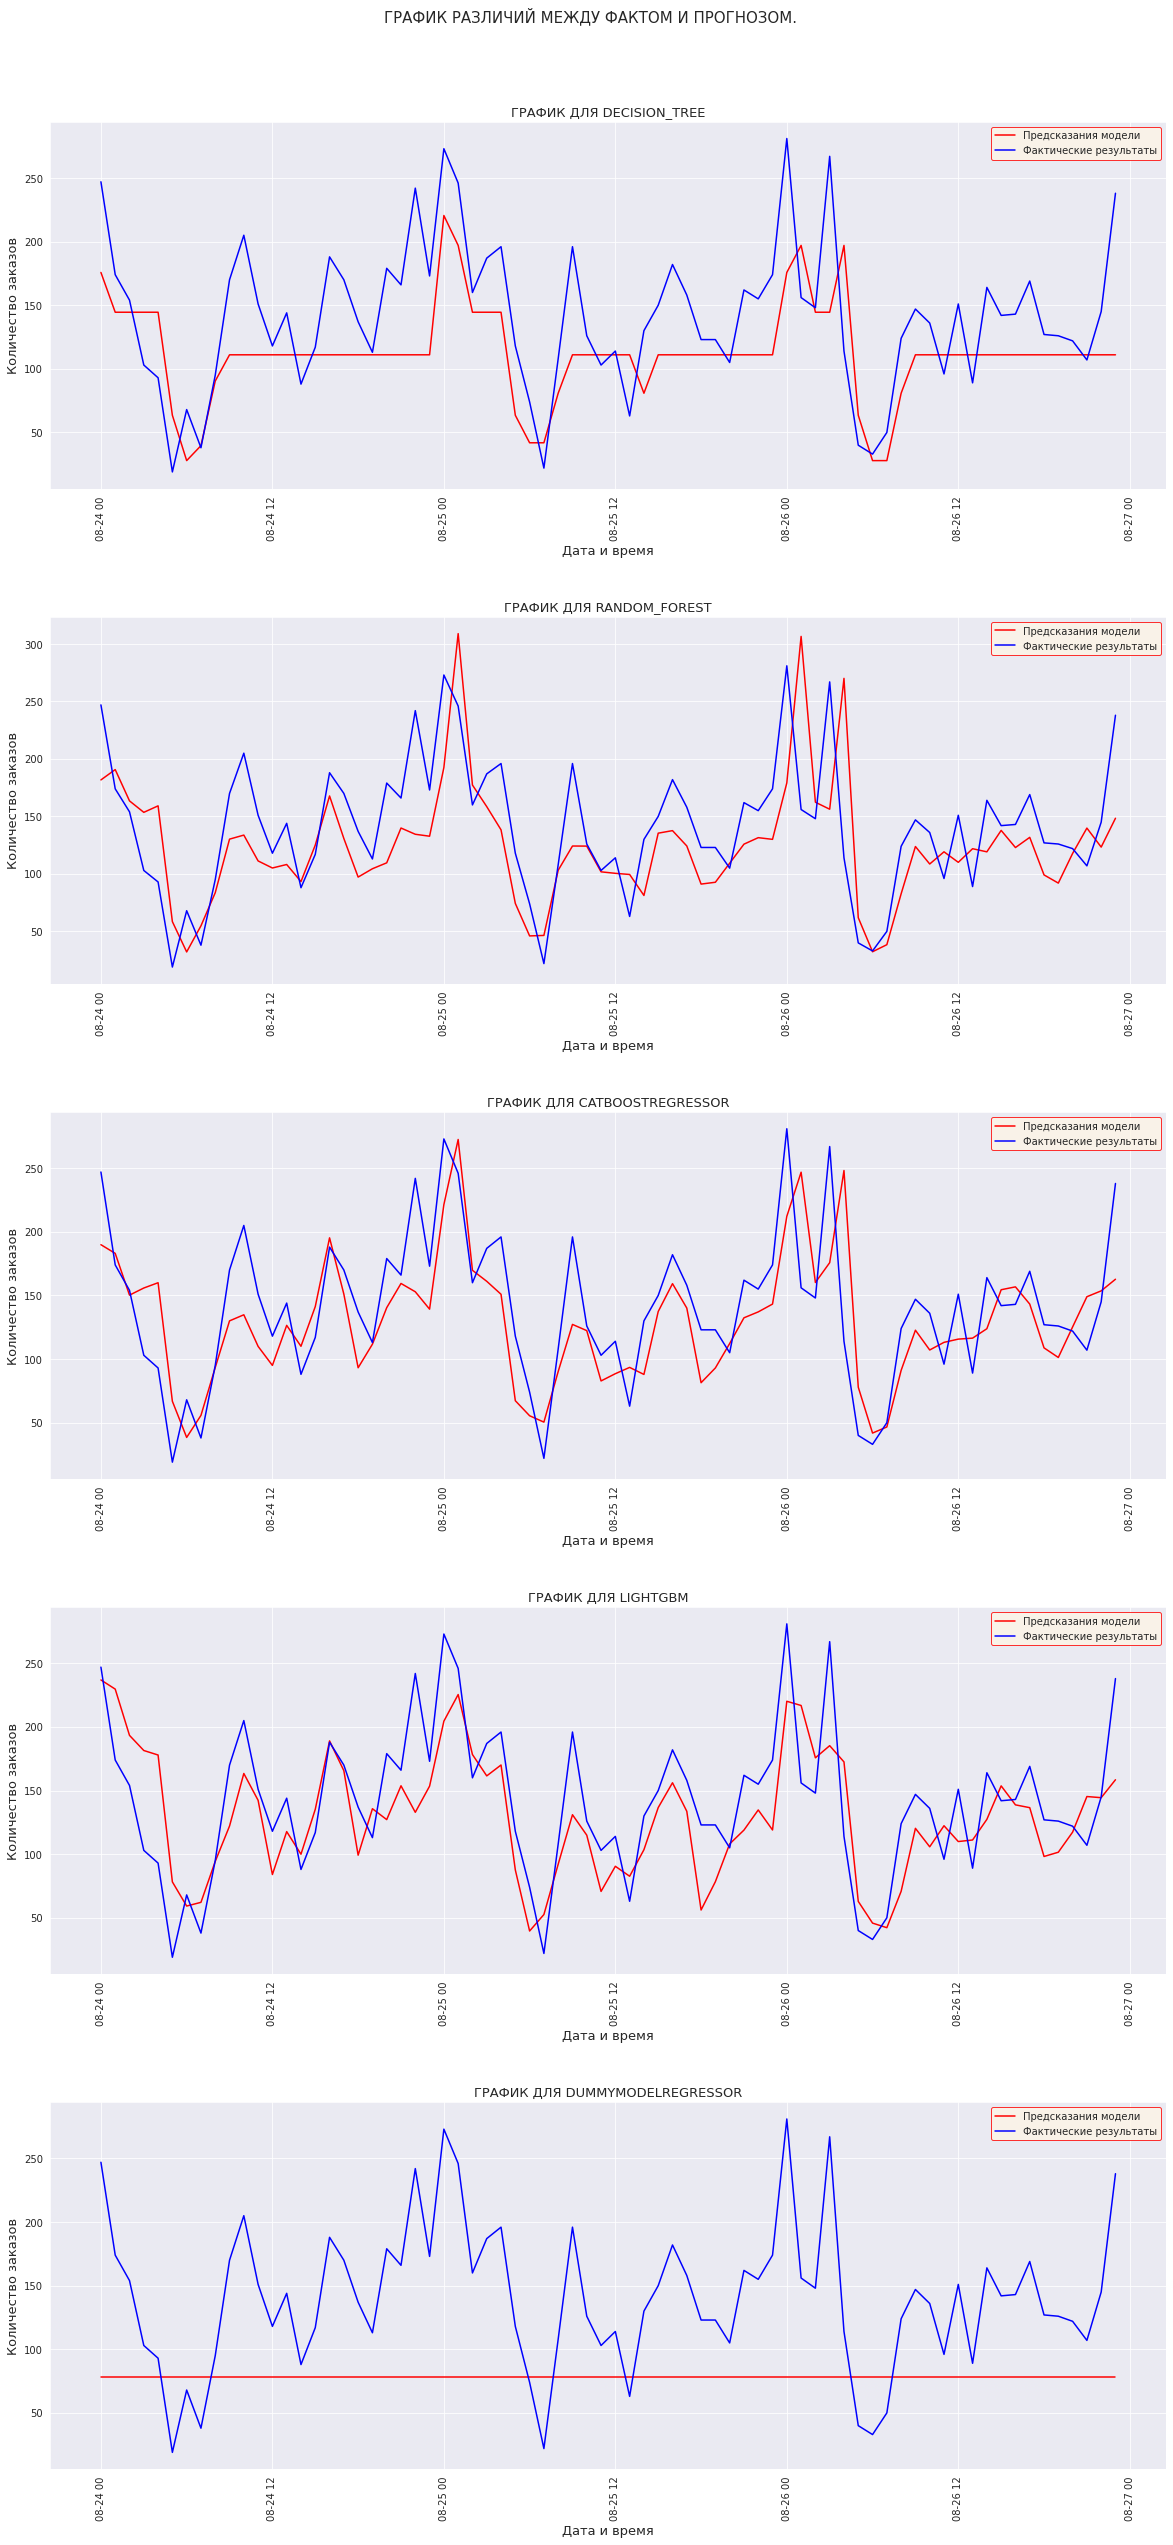

In [169]:
show_differences(target_test,dct_with_predict)